In [95]:
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt
import numpy as np
from transformers import AutoTokenizer, pipeline
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.model_selection import GridSearchCV


import re
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from wordcloud import WordCloud
from gensim.utils import simple_preprocess

from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
np.random.seed(42)

#### Workflow
- `Sentiment Analysis`: This would involve using natural language processing (NLP) techniques to analyze the language used in the reviews and classify them as positive, negative or neutral.
    - TextBlob: TextBlob is a Python library that provides a simple API for performing sentiment analysis. It uses a pre-trained sentiment analysis model to classify text as positive, negative, or neutral.

    - VaderSentiment: VaderSentiment is a Python library that provides a pre-trained sentiment analysis model specifically designed for analyzing social media text. It uses a lexicon-based approach to analyze the sentiment of text data and provides scores for positivity, negativity, and neutrality.

    - Hugging Face Transformers: Hugging Face Transformers is a Python library that provides a wide range of pre-trained natural language processing models, including models for sentiment analysis.

    - spaCy: spaCy is a Python library that provides a wide range of natural language processing tools, including a pre-trained sentiment analysis model.

- `Frequency analysis` involves analyzing the frequency of individual words or phrases in a given text or corpus. This can be useful for identifying common themes or topics in the text, as well as for identifying commonly used words or phrases. For example, in a collection of customer reviews for a product, frequency analysis could be used to identify the most commonly mentioned features or the most commonly used words to describe the product.
    
- `Topic Modeling`: Another important aspect of analyzing reviews would be to identify the main topics or themes that customers are discussing. This would involve using topic modeling techniques such as Latent Dirichlet Allocation (LDA) to identify the main topics that customers are discussing and the frequency of these topics.

- `Visualization`

### Sentiment Analysis

#### TextBlob

In [96]:
#load data
df = pd.read_csv("data/clean_all_reviews.csv")
df.head()

,reviews
0,worst experience life trying deal customer ser...
1,due code sharing cathay pacific downgraded ba ...
2,lhr check quick first wing quickly security. f...
3,recommend british airways all. tried call cust...
4,absolutely horrible experience. booked ticket ...


In [97]:
# Define a function to calculate the sentiment polarity of a text using TextBlob
def get_sentiment(text):
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    if polarity > 0:
        return 'positive'
    elif polarity < 0:
        return 'negative'
    else:
        return 'neutral'

# Apply the function to the all_reviews column of the DataFrame to calculate the sentiment polarity of each review
df['polarity'] = df['reviews'].apply(get_sentiment)

# Print the DataFrame to see the results
df.head()

,reviews,polarity
0,worst experience life trying deal customer ser...,negative
1,due code sharing cathay pacific downgraded ba ...,negative
2,lhr check quick first wing quickly security. f...,positive
3,recommend british airways all. tried call cust...,negative
4,absolutely horrible experience. booked ticket ...,negative


In [98]:
def plot_polarity(col):
    # Count the occurrences of each sentiment
    sentiment_counts = df[col].value_counts()
    print(sentiment_counts)
    fig, ax = plt.subplots()
    ax.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%')
    ax.set_title('Sentiment Distribution')
    plt.show()

polarity
positive    2512
negative     978
neutral       19
Name: count, dtype: int64


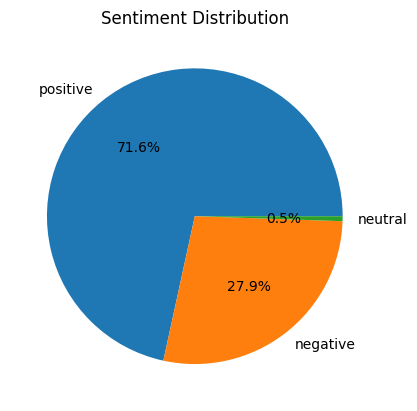

In [99]:
plot_polarity('polarity')

#### Hugging Face Transformer

In [100]:
df.head()

,reviews,polarity
0,worst experience life trying deal customer ser...,negative
1,due code sharing cathay pacific downgraded ba ...,negative
2,lhr check quick first wing quickly security. f...,positive
3,recommend british airways all. tried call cust...,negative
4,absolutely horrible experience. booked ticket ...,negative


In [101]:
def hugging_face(model, col):    
    # Define the sentiment analysis pipeline
    classifier = pipeline("sentiment-analysis", max_length=500, truncation=True, model=model)

    # Define a function to classify the sentiment of a single text
    def get_sentiment(text):
        result = classifier(text)
        return result[0]['label']

    # Apply the function to the all_reviews column of the DataFrame to classify the sentiment of each review
    df[col] = df['reviews'].apply(get_sentiment)

    # Print the DataFrame to see the results
    df.head()

In [102]:
# hugging_face('distilbert-base-uncased-finetuned-sst-2-english', 'hugging-sentiment')

In [103]:
# plot_polarity('hugging-sentiment')

In [104]:
# hugging_face('nlptown/bert-base-multilingual-uncased-sentiment', 'hugging-npl-town')

In [105]:
# plot_polarity('hugging-npl-town')

In [106]:
# hugging_face('cardiffnlp/twitter-roberta-base-emotion', 'hugging-cardiffnlp')

In [107]:
# plot_polarity('hugging-cardiffnlp')

In [108]:
# hugging_face('cardiffnlp/twitter-xlm-roberta-base', 'hugging-roberta')

In [109]:
# plot_polarity('hugging-roberta')

In [110]:
# hugging_face('cardiffnlp/twitter-roberta-base-sentiment', 'hugging-roberta-english')

In [111]:
# plot_polarity('hugging-roberta-english')

In [112]:
df.head()

,reviews,polarity
0,worst experience life trying deal customer ser...,negative
1,due code sharing cathay pacific downgraded ba ...,negative
2,lhr check quick first wing quickly security. f...,positive
3,recommend british airways all. tried call cust...,negative
4,absolutely horrible experience. booked ticket ...,negative


#### Vader Sentiment

In [113]:
# Define a function to calculate the sentiment polarity of a text using vaderSentiment
def get_sentiment(text):
    analyzer = SentimentIntensityAnalyzer()
    scores = analyzer.polarity_scores(text)
    if scores['compound'] > 0:
        return 'positive'
    elif scores['compound'] < 0:
        return 'negative'
    else:
        return 'neutral'

# Apply the function to the all_reviews column of the DataFrame to calculate the sentiment polarity of each review
df['vader_polarity'] = df['reviews'].apply(get_sentiment)

# Print the DataFrame to see the results
df.head()

,reviews,polarity,vader_polarity
0,worst experience life trying deal customer ser...,negative,negative
1,due code sharing cathay pacific downgraded ba ...,negative,negative
2,lhr check quick first wing quickly security. f...,positive,positive
3,recommend british airways all. tried call cust...,negative,positive
4,absolutely horrible experience. booked ticket ...,negative,negative


vader_polarity
positive    2379
negative    1115
neutral       15
Name: count, dtype: int64


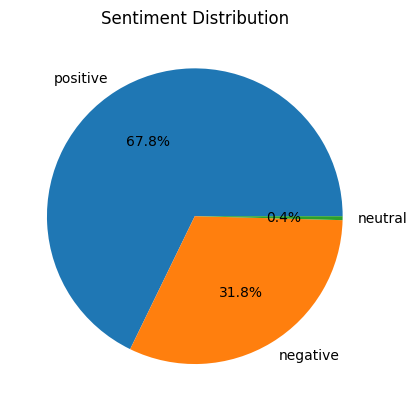

In [114]:
plot_polarity('vader_polarity')

### Frequency Analysis

In [115]:
def freq_analysis(df):
    # Tokenize the text data
    tokens = word_tokenize(' '.join(df))
    tokens = [word.strip(",.-") for word in tokens]

    # Perform frequency analysis
    freqdist = FreqDist(tokens)
    top_words = freqdist.most_common(11)
    top_words.pop(0)
    print(top_words)

    # Create a bar chart of the top 10 most frequent words
    plt.figure(figsize=(10, 6))
    sns.barplot(x=[w[1] for w in top_words], y=[w[0] for w in top_words], palette='Blues_r')
    plt.title('Top 10 most frequent words')
    plt.xlabel('Frequency')
    plt.ylabel('Word')
    plt.show()

    # Create a histogram of word frequencies
    # plt.figure(figsize=(10, 6))
    # freqdist.plot(30, cumulative=False)
    # plt.title('Word frequency distribution')
    # plt.xlabel('Frequency')
    # plt.ylabel('Number of words')
    # plt.show()

    wordcloud = WordCloud(width=800, height=800, background_color='white', max_words=100, contour_width=3, contour_color='steelblue')
    wordcloud.generate_from_frequencies(freqdist)
    plt.figure(figsize=(8, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

[('flight', 6210), ('ba', 4490), ('service', 2670), ('seat', 2283), ('food', 2271), ('london', 2111), ('crew', 2076), ('british', 2050), ('airways', 2033), ('seats', 2010)]


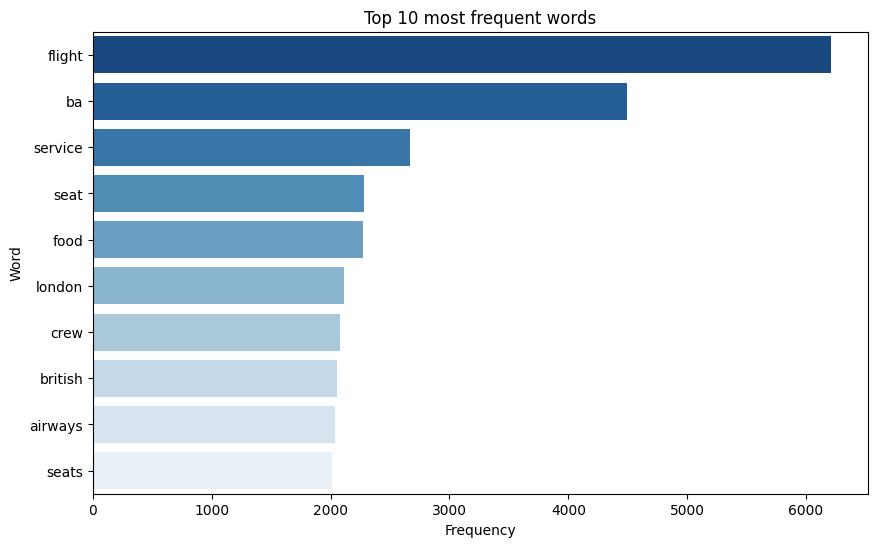

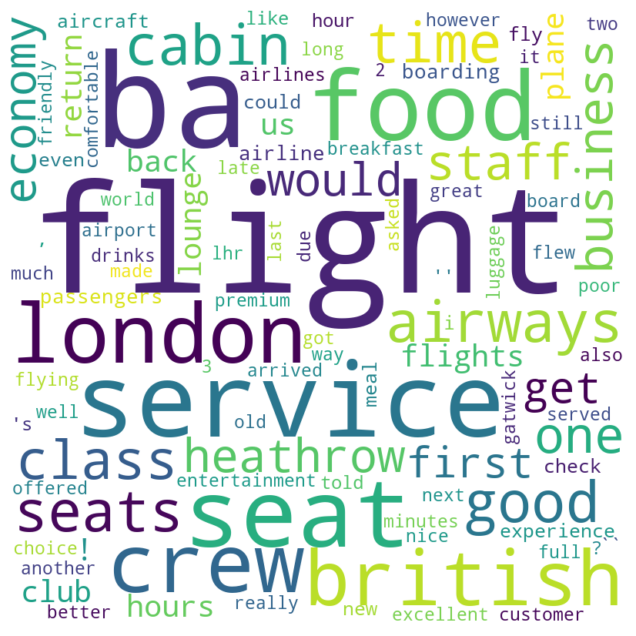

In [116]:
freq_analysis(df['reviews'])

In [117]:
negative_reviews = df[df.polarity == 'negative']
positive_reviews = df[df.polarity == 'positive']

[('flight', 1682), ('ba', 1229), ('service', 696), ('british', 674), ('airways', 659), ('london', 638), ('seat', 608), ('food', 555), ('seats', 519), ('class', 509)]


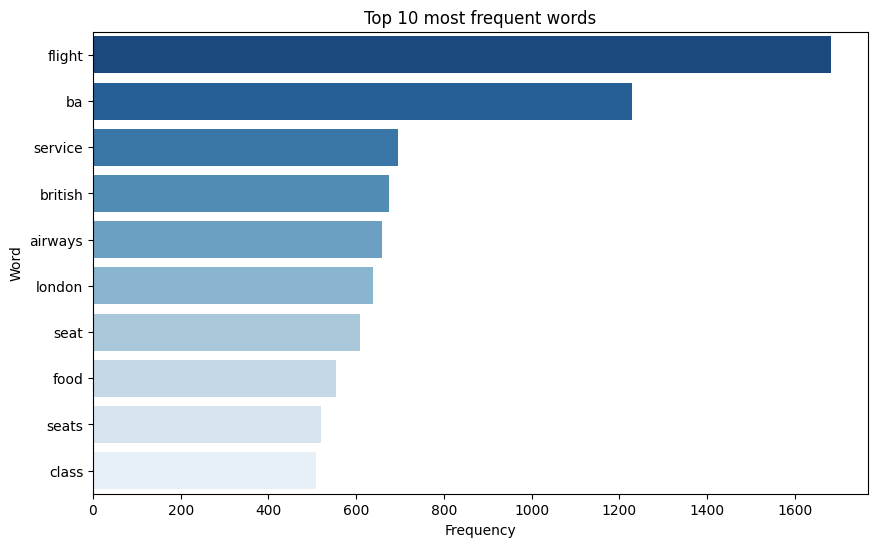

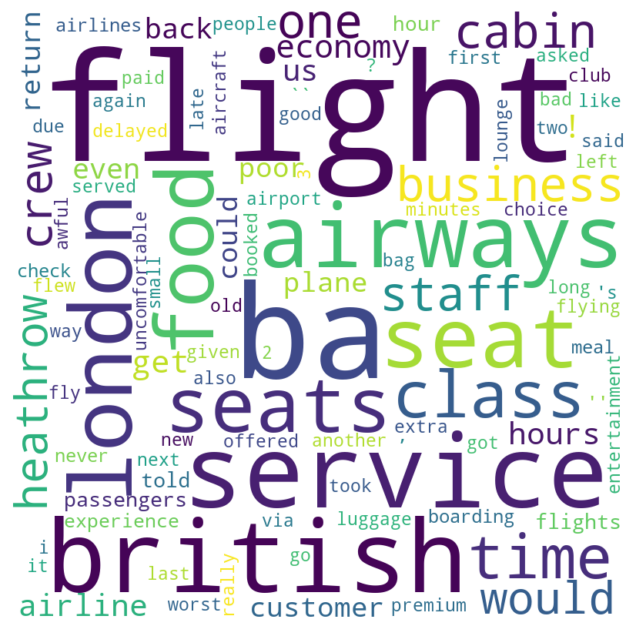

In [118]:
freq_analysis(negative_reviews['reviews'])

[('flight', 4507), ('ba', 3246), ('service', 1968), ('good', 1872), ('food', 1714), ('crew', 1696), ('seat', 1670), ('time', 1496), ('seats', 1487), ('london', 1465)]


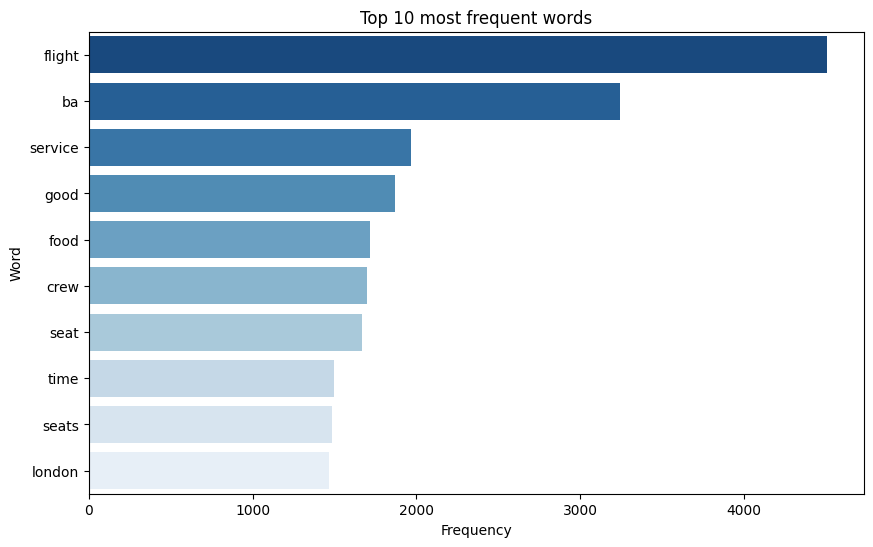

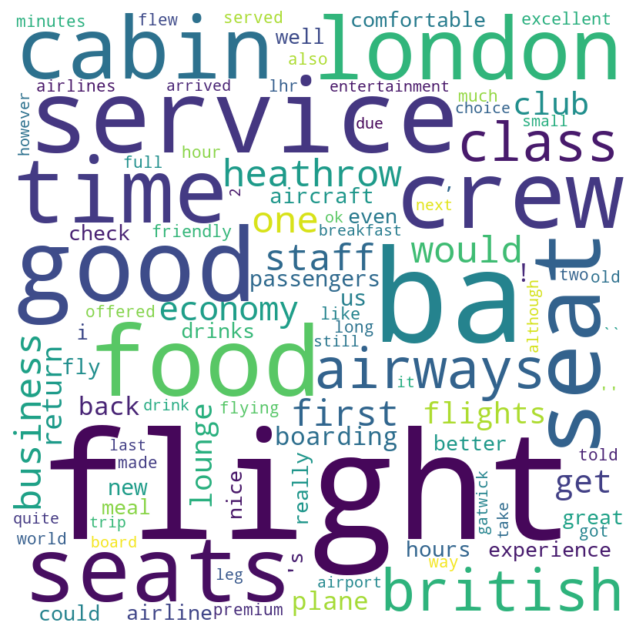

In [119]:
freq_analysis(positive_reviews['reviews'])

#### Topic Modeling Using LDA

In [120]:
# import nltk
# nltk.download('wordnet')

In [121]:
# Define a function for text cleaning
def clean_text(text):
    text = str(text)
    text = re.sub('\n', ' ', text) # Remove new line characters
    text = re.sub('\r', ' ', text)
    text = re.sub('[^a-zA-Z]', ' ', text) # Remove non-alphabet characters
    text = text.lower() # Convert text to lowercase
    words = text.split() # Split text into words
    words = [word for word in words if word not in STOPWORDS] # Remove stopwords
    
    lem = WordNetLemmatizer() # Initialize lemmatizer
    words = [lem.lemmatize(word, pos='v') for word in words] # Lemmatize verbs
    words = [lem.lemmatize(word, pos='n') for word in words] # Lemmatize nouns
    words = [lem.lemmatize(word, pos='a') for word in words] # Lemmatize adjectives
    words = [lem.lemmatize(word, pos='r') for word in words] # Lemmatize adverbs
    return ' '.join(words) # Join the cleaned words back into a string

In [122]:
# Clean the text data
df['cleaned_text'] = df['reviews'].apply(clean_text)
df.head()

In [129]:
def lda_analysis(df):
    """
    Perform LDA analysis on the given dataframe.

    Args:
    - df: A pandas dataframe object containing the cleaned text.

    Returns:
    - None
    """
    # Convert cleaned text to a list of words
    data = df['cleaned_text'].tolist()
    data = [simple_preprocess(str(doc)) for doc in data]

    # Create a dictionary of words and their frequency counts
    dictionary = corpora.Dictionary(data)

    # Convert the text data into a bag of words format
    corpus = [dictionary.doc2bow(doc) for doc in data]

    # Train an LDA model on the corpus
    lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=10,
                         random_state=42,
                         update_every=1,
                         passes=10,
                         alpha='auto',
                         per_word_topics=True)

    # Print the top topics and their associated keywords
    for idx, topic in lda_model.print_topics(num_topics=10):
        print(f'Topic: {idx+1} \nKeywords: {topic}\n')

    # Create a WordCloud object for each topic
    num_topics = 10
    cols = 5
    rows = (num_topics - 1) // cols + 1  # Calculate the number of rows needed
    fig, axs = plt.subplots(rows, cols, figsize=(20,8))
    for ax in axs.flatten():
        ax.axis('off')

    for topic_id in range(num_topics):
        # Get the top 10 words for the current topic
        topic_words = lda_model.show_topic(topic_id, topn=10)
        # Create a dictionary of word-frequency pairs for the topic
        word_freq = dict(topic_words)
        # Create a WordCloud object with the given dictionary
        wordcloud = WordCloud(width=200,
                              height=200,
                              background_color='white',
                              min_font_size=10,
                              contour_width=2,
                              contour_color='black').generate_from_frequencies(word_freq)
        # Plot the WordCloud for the current topic
        axs[topic_id // cols, topic_id % cols].imshow(wordcloud) 
        axs[topic_id // cols, topic_id % cols].set_title(f'Topic {topic_id+1}')

    plt.tight_layout()
    plt.show()

In [ ]:
lda_analysis(df)

`Topic 1`: This topic seems to be related to booking flights and dealing with customer service for British Airways, particularly around issues like telling customers about flight details and check-in processes.

`Topic 2`: This topic seems to be related to the boarding process and crew experience on British Airways flights, including things like the quality of the lounge and service on board.

`Topic 3`: This topic seems to be related to the different seat classes on British Airways flights, including business and economy, and the experience of flying with the airline.

`Topic 4`: This topic seems to be unrelated to British Airways specifically and instead appears to be focused on specific topics like food and drink options on flights.

`Topic 5`: This topic seems to be related to the overall flight experience on British Airways, including factors like the quality of the food, crew, and cabin.

`Topic 6`: This topic seems to be related to the overall experience of flying with an airline, including service, food, and cost.

`Topic 7`: This topic seems to be related to delays and issues with flights departing from London Heathrow Airport on British Airways, including the airline's response to these issues.

`Topic 8`: This topic seems to be related to specific flights, routes, and classes offered by British Airways, including attendant experience.

`Topic 9`: This topic seems to be related to specific food options on flights departing from various airports.

`Topic 10`: This topic seems to be related to specific airports and destinations served by British Airways, including headphone and musical instrument issues.

In [130]:
positive_reviews['cleaned_text'] = positive_reviews['reviews'].apply(clean_text)
negative_reviews['cleaned_text'] = negative_reviews['reviews'].apply(clean_text)

C:\Users\yeboa\AppData\Local\Temp\ipykernel_10776\2535522696.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_reviews['cleaned_text'] = positive_reviews['reviews'].apply(clean_text)
C:\Users\yeboa\AppData\Local\Temp\ipykernel_10776\2535522696.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_reviews['cleaned_text'] = negative_reviews['reviews'].apply(clean_text)


Topic: 1 
Keywords: 0.029*"ba" + 0.021*"seat" + 0.019*"fly" + 0.015*"flight" + 0.014*"service" + 0.014*"economy" + 0.013*"good" + 0.012*"food" + 0.012*"class" + 0.011*"airline"

Topic: 2 
Keywords: 0.024*"lhr" + 0.020*"am" + 0.017*"flight" + 0.015*"good" + 0.010*"clean" + 0.009*"zrh" + 0.009*"aircraft" + 0.009*"leg" + 0.008*"time" + 0.008*"entertainment"

Topic: 3 
Keywords: 0.033*"flight" + 0.025*"good" + 0.017*"crew" + 0.016*"food" + 0.016*"lhr" + 0.016*"ba" + 0.012*"seat" + 0.012*"lounge" + 0.011*"service" + 0.011*"cabin"

Topic: 4 
Keywords: 0.045*"flight" + 0.024*"ba" + 0.016*"hour" + 0.015*"book" + 0.015*"tell" + 0.013*"london" + 0.012*"airway" + 0.011*"british" + 0.011*"day" + 0.011*"customer"

Topic: 5 
Keywords: 0.011*"assistance" + 0.010*"airway" + 0.010*"help" + 0.010*"british" + 0.010*"baggage" + 0.008*"chicago" + 0.008*"connection" + 0.007*"disembark" + 0.006*"depart" + 0.005*"disability"

Topic: 6 
Keywords: 0.017*"af" + 0.009*"refund" + 0.009*"august" + 0.008*"helpline" 

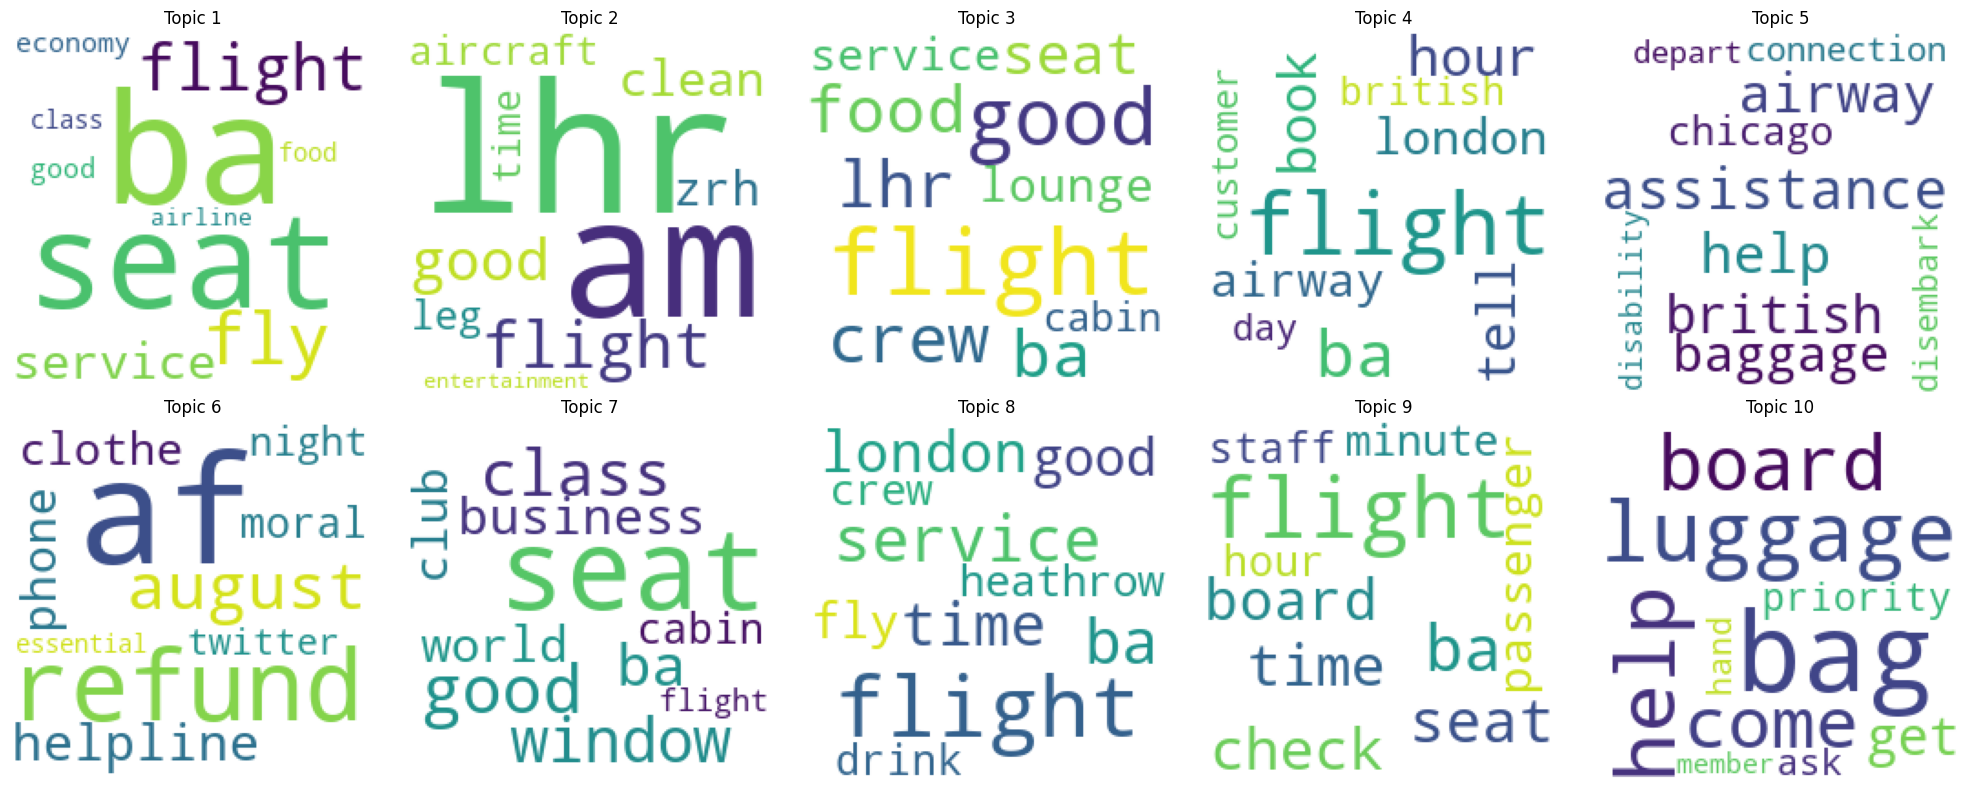

In [131]:
lda_analysis(positive_reviews)

`Topic 1`: Economy class service and food quality on British Airways flights  
`Topic 2`: Flight experiences departing from LHR airport, including aircraft cleanliness and entertainment options  
`Topic 3`: General positive experiences related to British Airways flights, including crew service and lounge access  
`Topic 4`: Customer service issues related to booking and communication with British Airways  
`Topic 5`: Assistance and support for passengers with disabilities or special needs on British Airways flights  
`Topic 6`: Miscellaneous complaints or inquiries about British Airways services and policies  
`Topic 7`: Business and first-class experiences on British Airways flights, including seat comfort and cabin design  
`Topic 8`: General flight experiences with British Airways, including crew service and on-board amenities  
`Topic 9`: Check-in and boarding experiences with British Airways, including seat selection and staff interactions  
`Topic 10`: Issues related to baggage handling and luggage policies on British Airways flights.  

Topic: 1 
Keywords: 0.028*"flight" + 0.021*"ba" + 0.014*"hour" + 0.013*"check" + 0.012*"airway" + 0.012*"british" + 0.011*"time" + 0.009*"delay" + 0.008*"book" + 0.008*"tell"

Topic: 2 
Keywords: 0.019*"flight" + 0.012*"serve" + 0.011*"meal" + 0.010*"time" + 0.010*"fly" + 0.010*"food" + 0.009*"drink" + 0.009*"crew" + 0.008*"service" + 0.008*"london"

Topic: 3 
Keywords: 0.038*"seat" + 0.023*"flight" + 0.018*"class" + 0.016*"business" + 0.015*"ba" + 0.013*"food" + 0.010*"british" + 0.010*"airline" + 0.010*"cabin" + 0.010*"airway"

Topic: 4 
Keywords: 0.034*"ba" + 0.023*"flight" + 0.015*"service" + 0.010*"london" + 0.010*"heathrow" + 0.009*"customer" + 0.008*"airline" + 0.008*"staff" + 0.008*"time" + 0.008*"travel"

Topic: 5 
Keywords: 0.015*"ba" + 0.012*"seat" + 0.009*"service" + 0.008*"pay" + 0.007*"flight" + 0.007*"staff" + 0.007*"check" + 0.007*"bag" + 0.007*"london" + 0.006*"year"

Topic: 6 
Keywords: 0.006*"mini" + 0.004*"doha" + 0.003*"salaam" + 0.003*"jack" + 0.003*"dar" + 0.003*

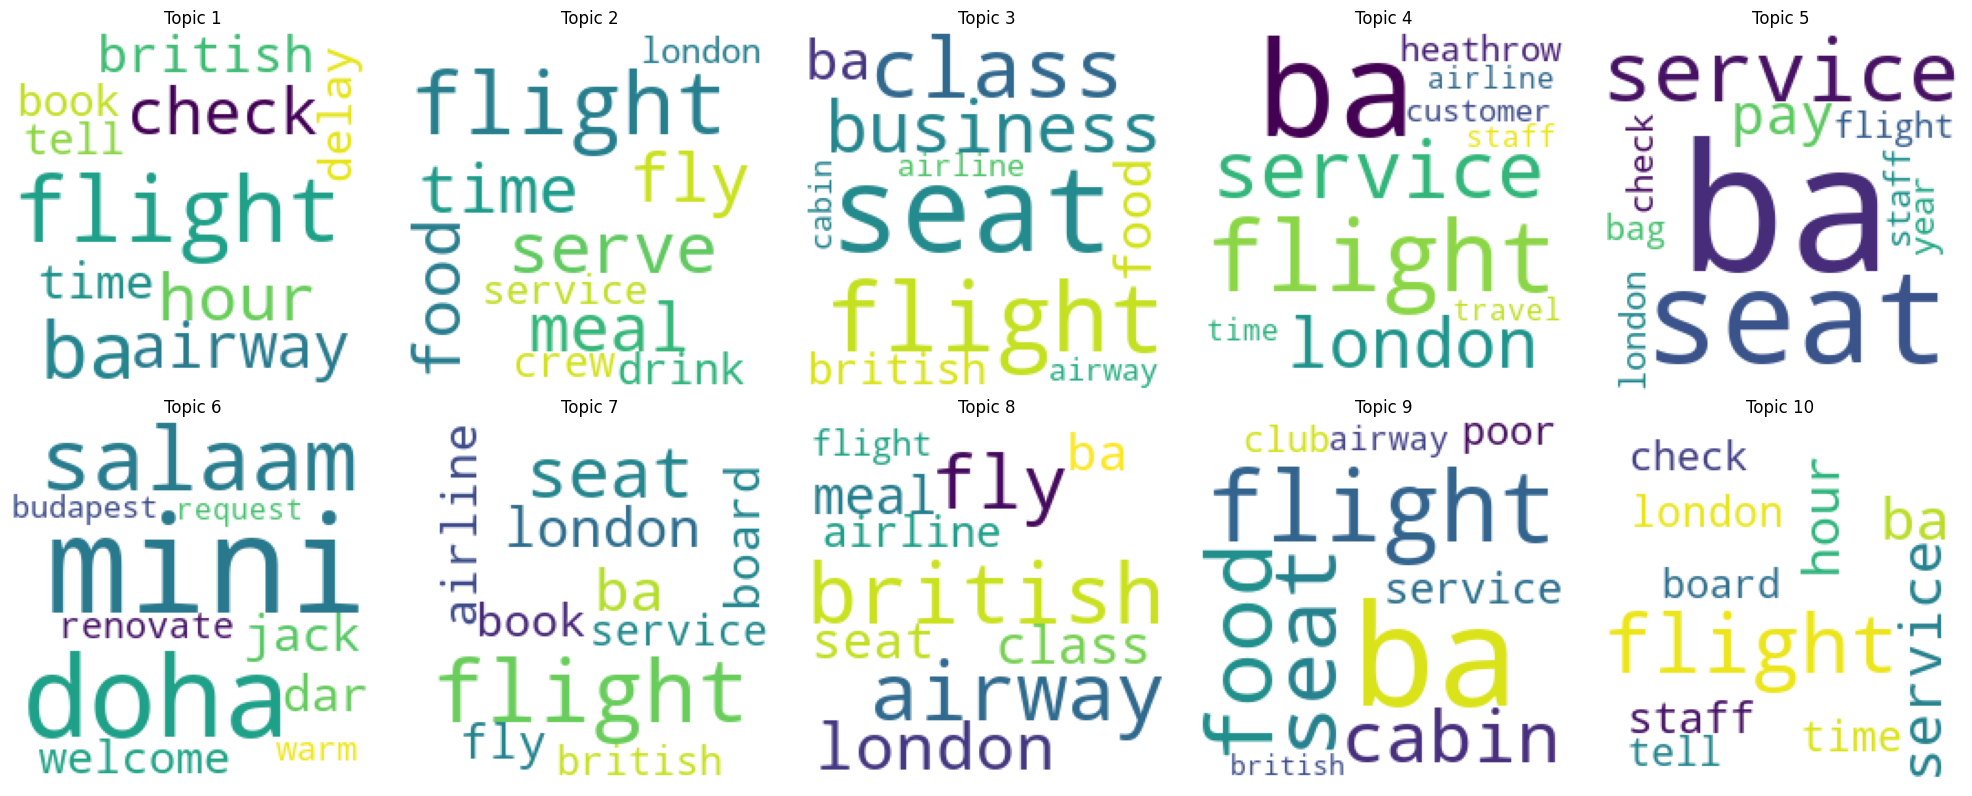

In [132]:
lda_analysis(negative_reviews)

`Topic 1` seems to focus on issues related to flight delays and check-in times.  

`Topic 2` is related to the quality of in-flight meals, drinks, and service provided by the crew.  

`Topic 3` is about the seat and cabin class experience, including business class and food.  

`Topic 4` seems to be about the overall service provided by the airline, including customer service and staff quality.  

`Topic 5` appears to be related to the cost of services provided by British Airways, including seating and baggage fees.  

`Topic 6` is less clear, but appears to be unrelated to the previous topics, and might involve a review of a specific airport or lounge.  

`Topic 7` is about booking and boarding flights with British Airways, as well as general airline service.  

`Topic 8` seems to be a more detailed analysis of the seat and meal quality provided by British Airways.  

`Topic 9` is about the quality of service provided in the cabin, particularly for club class passengers.  

`Topic 10` is related to issues of service quality and staff performance during flights, as well as the overall travel experience.  